In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import pickle

In [3]:
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
ratings = pd.read_csv('ratings.csv')

In [4]:
movies.tail()
movies['genres'] = movies['genres'].str.replace('|',' ')

In [5]:
len(movies.movieId.unique())

9742

In [6]:
len(ratings.movieId.unique())

9724

In [7]:
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)
movie_list_rating = ratings_f.movieId.unique().tolist()

In [8]:
len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100

98.7990145760624

In [9]:
len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100

59.67213114754099

In [10]:
movies = movies[movies.movieId.isin(movie_list_rating)]

In [11]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [12]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [13]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)

In [14]:
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun


In [15]:
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy Romance


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(9625, 1675)


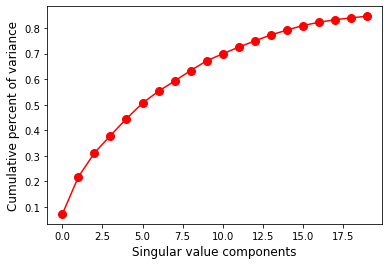

In [19]:
# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [20]:
n = 20
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [21]:
latent_matrix.shape

(9625, 20)

In [22]:
ratings_f.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [23]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [24]:
ratings_f2.head(3)

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [25]:
len(ratings_f.movieId.unique())

9625

In [26]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(
                             latent_matrix_2,
                             index=Final.title.tolist())

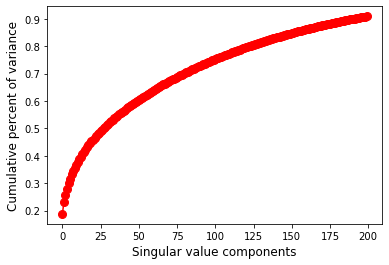

In [27]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
a_1 = np.array(latent_matrix_1_df.loc['The Good Dinosaur (2015)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc['The Good Dinosaur (2015)']).reshape(1, -1)
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)
hybrid = ((score_1 + score_2)/2.0)
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )
similar.sort_values('hybrid', ascending=False, inplace=True)
similar[1:].head(11)

,content,collaborative,hybrid
Digimon: The Movie (2000),0.833870,0.654674,0.744272
Ice Age: A Mammoth Christmas (2011),0.833870,0.579074,0.706472
Inside Out (2015),0.970673,0.351215,0.660944
"Bird People in China, The (Chûgoku no chôjin) (1998)",0.651033,0.654674,0.652854
Winnie the Pooh and the Honey Tree (1966),0.722351,0.579074,0.650712
Beauty and the Beast: The Enchanted Christmas (1997),0.714611,0.579074,0.646843
Mind Game (2004),0.653781,0.634317,0.644049
North Pole: Open For Christmas (2015),0.697836,0.579074,0.638455
The Boy and the Beast (2015),0.582161,0.654674,0.618418
"Ewok Adventure, The (a.k.a. Caravan of Courage: An Ewok Adventure) (1984)",0.639150,0.585302,0.612226
